In [2]:
from pathlib import Path
import librosa
import torch
from argparse import ArgumentParser
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import tqdm
from IPython.display import Audio, display

import numpy as np

import sys
sys.path += ['../music-translation/']

import utils
import wavenet_models
from utils import save_audio
from wavenet import WaveNet
from wavenet_generator import WavenetGenerator
from nv_wavenet_generator import NVWavenetGenerator
from nv_wavenet_generator import Impl

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
dict = {'..\\music-translation\\musicnet\\encoded\\Bach_Solo_Cello': 0, 
       '..\\music-translation\\musicnet\\encoded\\Bach_Solo_Piano': 1,
        '..\\music-translation\\musicnet\\encoded\\Beethoven_Accompanied_Violin': 2,
        '..\\music-translation\\musicnet\\encoded\\Beethoven_Solo_Piano': 3,
        '..\\music-translation\\musicnet\\encoded\\Beethoven_String_Quartet': 4,
        '..\\music-translation\\musicnet\\encoded\\Cambini_Wind_Quintet': 5
       }

In [40]:
encoded = []
labels = []
for directory in Path('../music-translation/musicnet/encoded').iterdir():
    for path in directory.iterdir():
        labels.append(dict[str(directory)])
        encoded += [torch.load(path, device)]
encoded = torch.cat(encoded, dim=0)

In [44]:
encoded.size()

torch.Size([203, 64, 200])

torch.Size([12800])
torch.Size([203])
torch.Size([12800, 203])


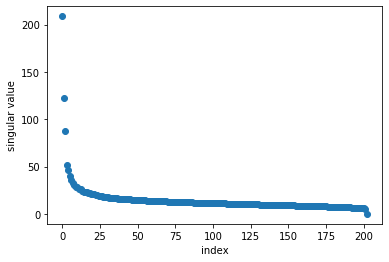

In [26]:
flattened = torch.flatten(encoded, 1)
col_means = torch.mean(flattened, 0)
print(col_means.shape)

demeaned = flattened - col_means
U, S, V = torch.svd(demeaned, compute_uv = True)
print(S.shape)
print(V.shape)

plt.scatter([i for i in range(203)], S.cpu().numpy())
plt.xlabel("index")
plt.ylabel("singular value")
plt.show()

In [79]:
encoded_np = encoded.cpu().numpy()
flattened_np = flattened.cpu().numpy()
print(flattened_np.shape)
print(flattened_np[:,0].shape)
print(flattened_np[:,1].shape)

print(encoded_np.shape)
print(encoded_np[:,0].shape)
print(encoded_np[:,1].shape)

(203, 12800)
(203,)
(203,)
(203, 64, 200)
(203, 200)
(203, 200)


(203, 2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

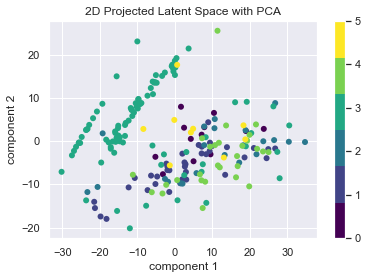

In [211]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(2)
projected = pca.fit_transform(flattened_np)
print(projected.shape)
plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none',
            cmap=plt.cm.get_cmap('viridis', 6))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('2D Projected Latent Space with PCA')
plt.colorbar();

(203, 3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.92, 'Projected Latent Space with PCA')

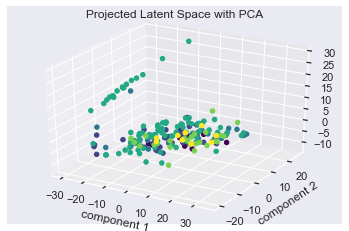

In [210]:
pca = PCA(3)
projected = pca.fit_transform(flattened_np)
print(projected.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(projected[:, 0], projected[:, 1], projected[:, 2], c=labels, alpha=1,
            cmap=plt.cm.get_cmap('viridis', 6))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('3D Projected Latent Space with PCA')

(203, 3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

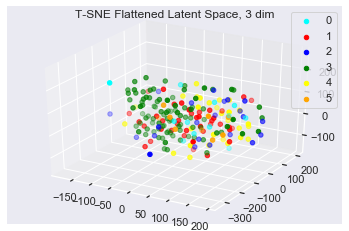

In [214]:
from sklearn import manifold

X_encoded = flattened_np

# Compute t-SNE embedding of latent space
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded)
print(X_tsne.shape)

scatter_x = X_tsne[:,0]
scatter_y = X_tsne[:,1]
scatter_z = X_tsne[:,2]
group = labels
cdict = {0: 'cyan', 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange'}

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g, s = 20)
plt.title('T-SNE Flattened Latent Space, 3 dim');
ax.legend()
plt.show()

(203, 2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

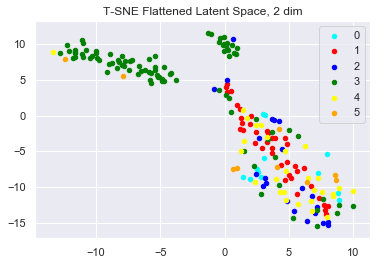

In [215]:
from sklearn import manifold

X_encoded = flattened_np

# Compute t-SNE embedding of latent space
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded)
print(X_tsne.shape)

scatter_x = X_tsne[:,0]
scatter_y = X_tsne[:,1]
group = labels
cdict = {0: 'cyan', 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 20)
plt.title('T-SNE Flattened Latent Space, 2 dim');
ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

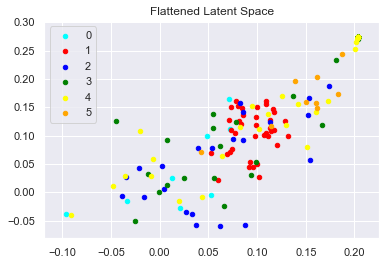

In [216]:
scatter_x = flattened_np[:,0]
scatter_y = flattened_np[:,1]
group = labels
cdict = {0: 'cyan', 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange'}

instrumentdict = {0: 'Bach Solo Cello', 
                  1: 'Bach Solo Piano',
                  2: 'Beethoven Accompanied Violin', 
                  3: 'Beethoven Solo Piano', 
                  4: 'Beethoven String Quartet',
                  5: 'Cambini Wind Quintet'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 20)
plt.title('Flattened Latent Space');
ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

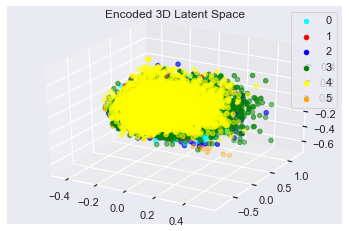

In [217]:
from mpl_toolkits import mplot3d

scatter_x = encoded_np[:,0]
scatter_y = encoded_np[:,1]
scatter_z = encoded_np[:,2]
group = labels
cdict = {0: 'cyan', 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange'}

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g, s = 20)
plt.title('Encoded 3D Latent Space');
ax.legend()
plt.show()